In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import join
import seaborn as sns
from PIL import Image
import cv2
import torch
import sys
sys.path.append('model_related')

from model import CNN1, CLASS_LABEL_DICT, transform
import train_model
from train_model import val_loader, test_loader, symbol_list
from card_processing import get_icons, display_card
from image_processing import contrast_enhancement, find_object_contours
from  model_metrics import get_predictions_and_labels, calculate_confusion_matrix, show_loss_curves, show_breakdown
import model_metrics

### Training
Train the model if you would like. The model path name is defined in `train_model.py`.

In [2]:
train_model.train()

### Metrics
#### Loss Curves
Look at loss curves during training process. Loss curves are saved as csvs during training and reloaded here. The csv file paths can be changed in `train_model.py`.

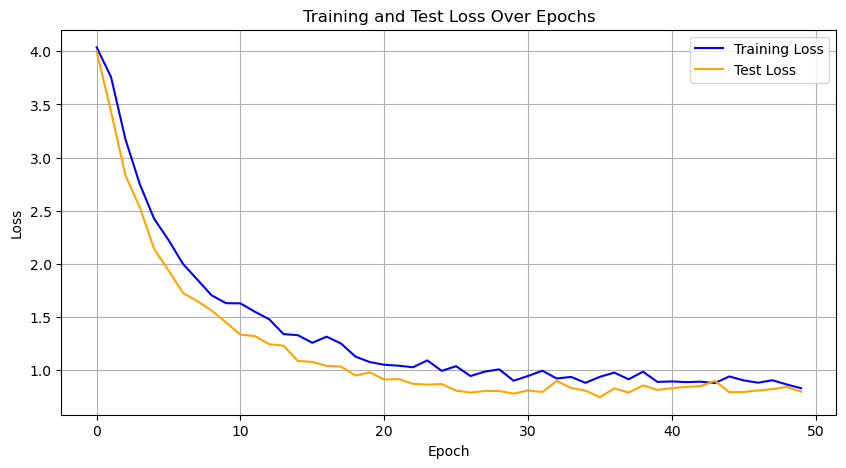

In [3]:
# Define and load the model
model_path = join("model_related", "model_v4.pth")
model = CNN1(num_classes=len(CLASS_LABEL_DICT))
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

# show training curves
show_loss_curves(join('model_related', 'train_loss.csv'), join('model_related', 'val_loss.csv'))

#### Confusion Matrices
Show confusion matrices for both validation and test data. For the icons that the model performs least accurately on, show their confusion matrix, precision, and recall. 

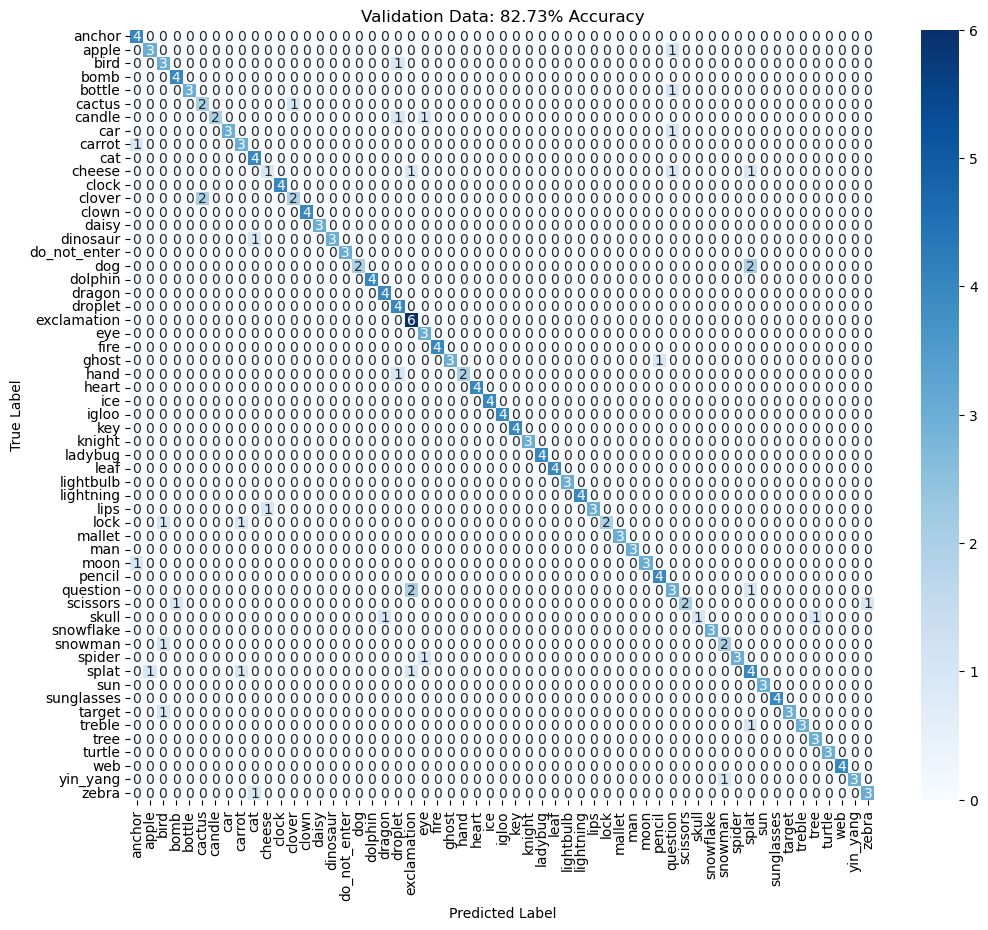

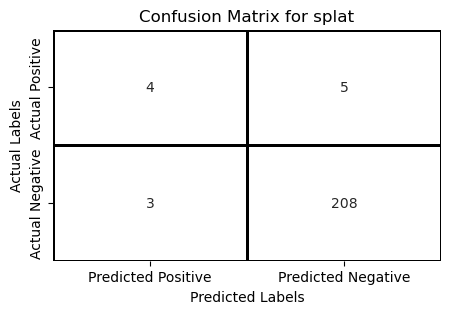

Precision: 44.440000000000005% 
Recall: 57.14%


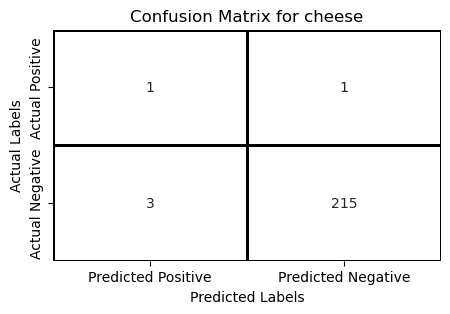

Precision: 50.0% 
Recall: 25.0%


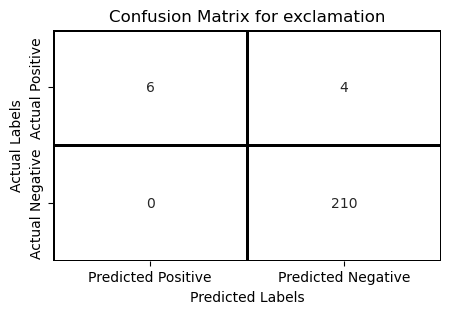

Precision: 60.0% 
Recall: 100.0%


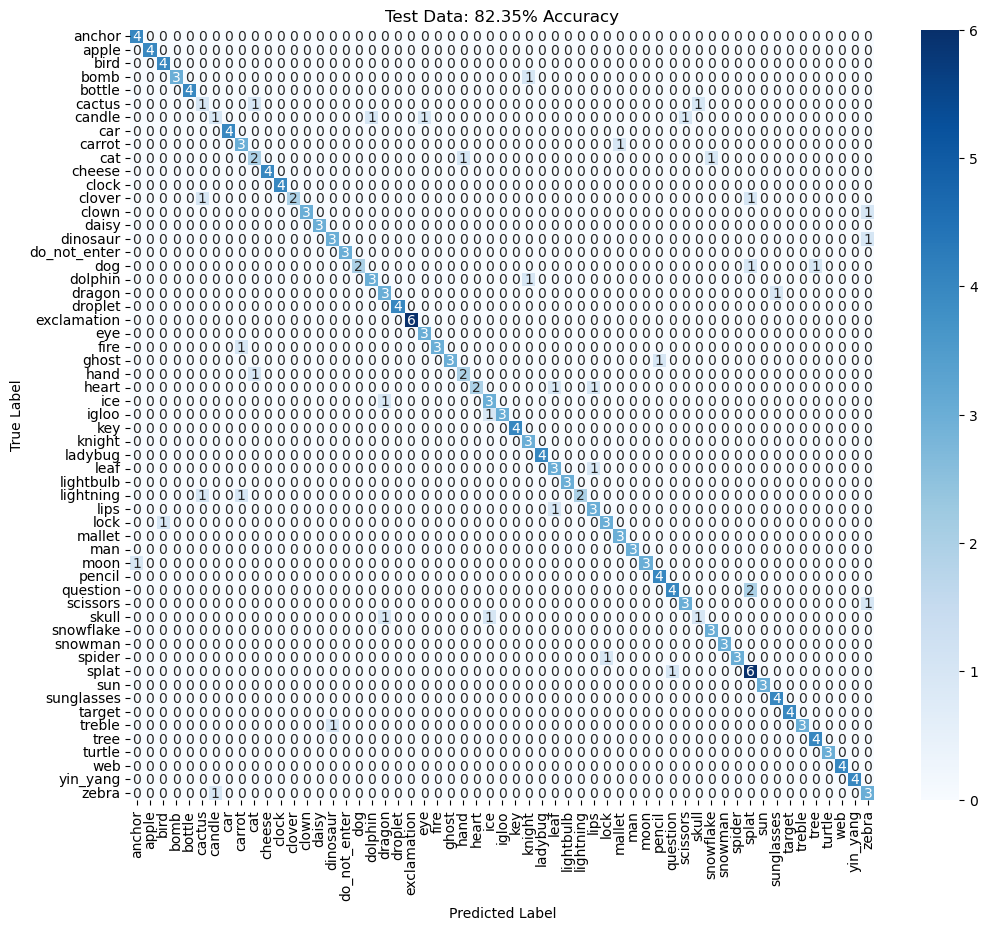

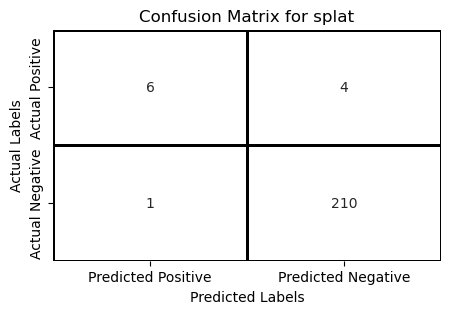

Precision: 60.0% 
Recall: 85.71%


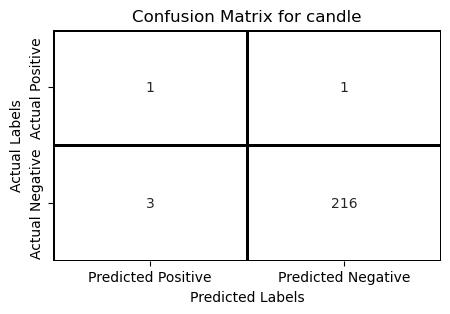

Precision: 50.0% 
Recall: 25.0%


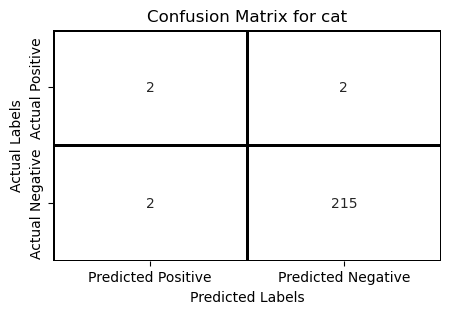

Precision: 50.0% 
Recall: 50.0%


In [9]:
# show confusion matrix
output_neurons = len(CLASS_LABEL_DICT)
# for i, model in enumerate([model]):
predictions, gt_labels = get_predictions_and_labels(model, test_loader)
val_pred, val_gt_labels = get_predictions_and_labels(model, val_loader)

test_cm = calculate_confusion_matrix(predictions, gt_labels, output_neurons)
val_cm = calculate_confusion_matrix(val_pred, val_gt_labels, output_neurons)

validation_accuracy = round(model_metrics.calculate_accuracy(val_cm), 4) * 100
test_accuracy = round(model_metrics.calculate_accuracy(test_cm), 4) * 100

# Plotting the confusion matrix with ordered labels
plt.figure(figsize=(12, 10))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', vmin=0,
            xticklabels=symbol_list,
            yticklabels=symbol_list)
plt.title(f'Validation Data: {validation_accuracy}% Accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print("\n")
show_breakdown(val_cm)

plt.figure(figsize=(12, 10))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', vmin=0,
            xticklabels=symbol_list,
            yticklabels=symbol_list)
plt.title(f'Test Data: {test_accuracy}% Accuracy')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print("\n")
show_breakdown(test_cm)


### Model Usage
Show an example of the model identifying a symbol.

In [5]:
# Load and preprocess the image
image_path = join("data", "test", "splat", "card02_01_contour_1.png")

image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0)

# Predict the label
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_label = torch.max(outputs, 1)


display(image)
print(f"Predicted Class: {CLASS_LABEL_DICT[predicted_label.item()]}")

Predicted Class: splat


Show the model recognizing icons on a pair of cards

There is a do_not_enter on both cards!


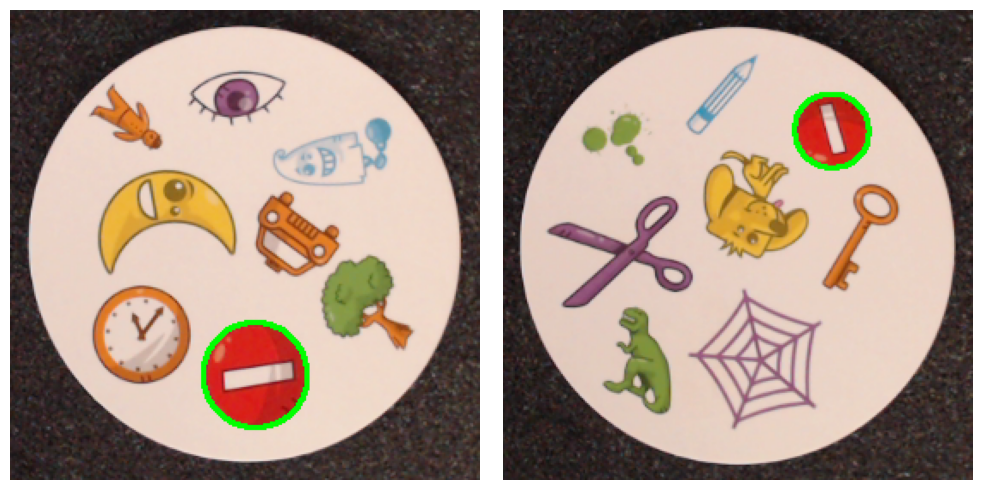

In [4]:
# the deck should be from your test data
# here it is playing_deck so we can limit how much data we are pushing to Github
deck = "playing_deck"
image1 = cv2.imread(join(deck, "card01_01.tif"))
image2 = cv2.imread(join(deck, "card02_01.tif"))
CLIP_LIMIT = 4.0
BINARY_THRESHOLD = 200
SYM_CARD_SIZE_RATIO = 1/20

card1, card1_contours = get_icons(image1, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
card2, card2_contours = get_icons(image2, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
matching_items = [item for item in card1 if item in card2]
match = matching_items[0]
card1_match_contour = card1_contours[card1.index(match)]
card2_match_contour = card2_contours[card2.index(match)]

print(f"There is a {match} on both cards!")
display_card(image1, image2, card1_match_contour, card2_match_contour)

Show how many times the model finds an incorrect number of icons on a card. It is either hallucinating an additional icon or failing to recognize that an icon is on the card.

There are 8 objects detected on card47_01.tif, with a minimum size of 301.5


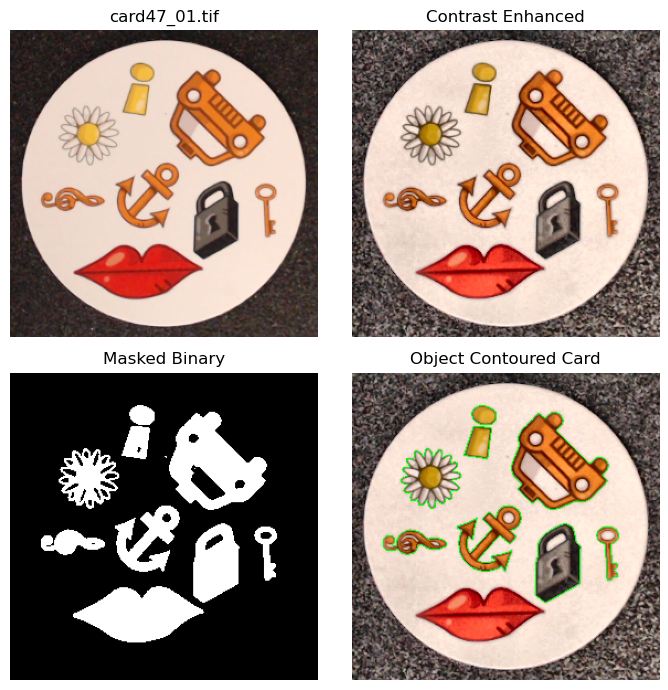

{'exclamation', 'anchor', 'treble', 'car', 'daisy', 'key', 'lock'}
There are 7 objects detected on card22_01.tif, with a minimum size of 1150.0


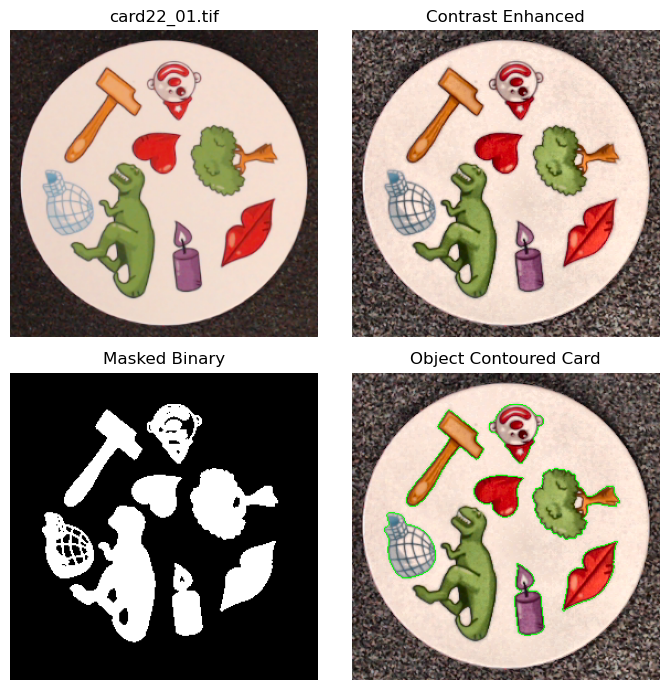

{'clown', 'heart', 'candle', 'tree', 'mallet', 'lips', 'igloo'}
There are 9 objects detected on card14_01.tif, with a minimum size of 229.5


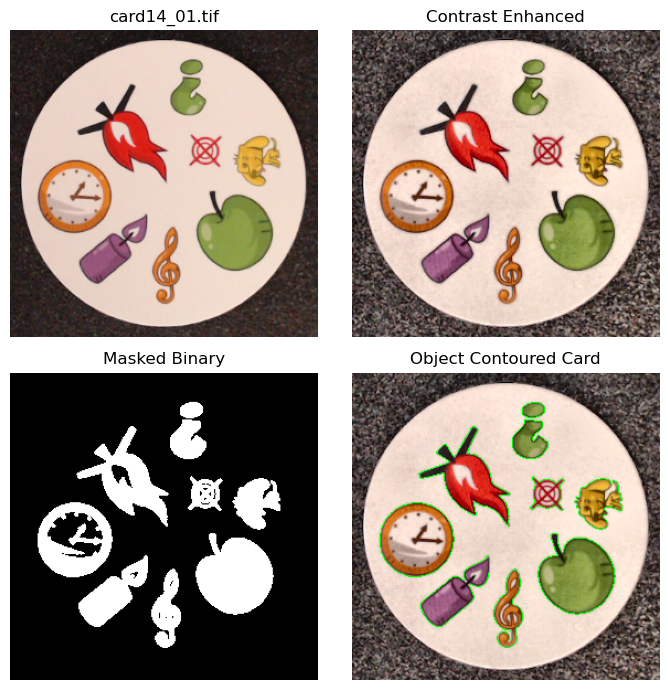

{'clock', 'splat', 'cheese', 'treble', 'candle', 'question', 'apple', 'fire', 'target'}
There are 9 objects detected on card15_01.tif, with a minimum size of 488.5


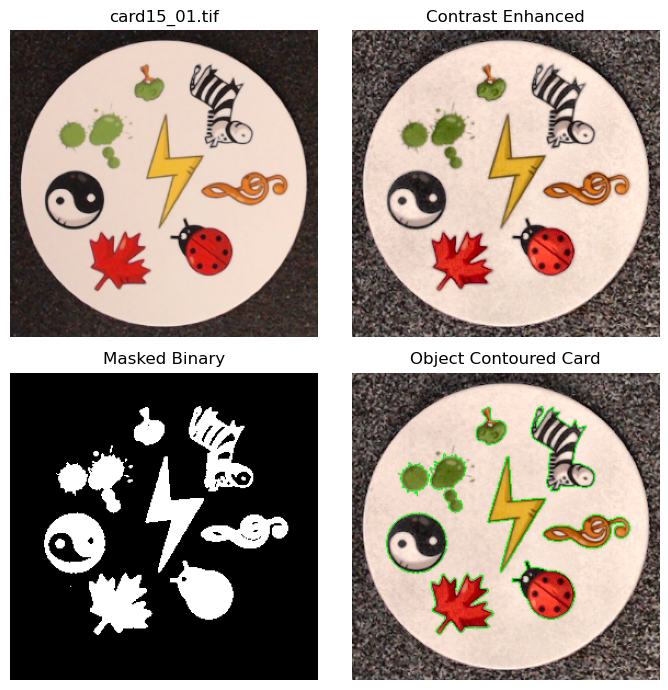

{'leaf', 'zebra', 'splat', 'ladybug', 'treble', 'yin_yang', 'lightning'}
There are 7 objects detected on card53_01.tif, with a minimum size of 1037.0


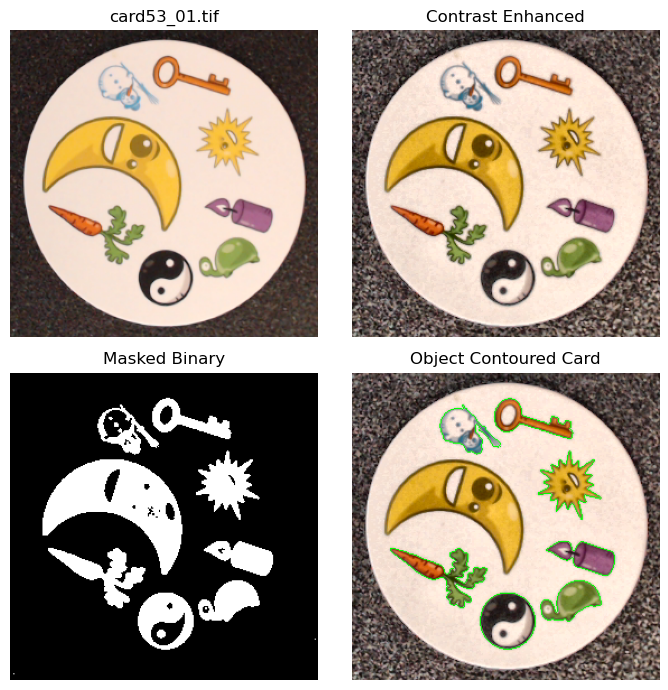

{'carrot', 'turtle', 'sun', 'snowman', 'candle', 'yin_yang', 'key'}
number of non-8 symbol cards:  5


In [5]:
counter = 0
    
for file in os.listdir(deck):
  image = cv2.imread(join(deck, file))
  if image is None:
    print(file)
    continue

  ##### KEPT FOR VISUALIZATION #####
  # # enhance the contrast in the lightness color space
  enhanced_RGB = contrast_enhancement(image, CLIP_LIMIT)

  # # draw the smaller contours for visualization
  [card_mask, masked_binary, object_contours
    ] = find_object_contours(enhanced_RGB.copy(), SYM_CARD_SIZE_RATIO, BINARY_THRESHOLD)
  contoured_output_image = enhanced_RGB.copy()
  cv2.drawContours(contoured_output_image, object_contours, -1, (0, 255, 0), thickness=1)

  contour_areas = [cv2.contourArea(contour) for contour in object_contours]

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  ##### #####

  icon_names, icon_contours = get_icons(image, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
  icon_names = set(icon_names)
  if len(icon_names) != 8:
    counter += 1
    print(f"There are {len(object_contours)} objects detected on {file}, with a minimum size of {min(contour_areas)}")
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    
    axs[0,0].imshow(image_rgb)
    axs[0,0].set_title(file)
    axs[0,0].axis("off")

    axs[0,1].imshow(enhanced_RGB, cmap="gray")
    axs[0,1].set_title(f'Contrast Enhanced')
    axs[0,1].axis("off")

    axs[1,0].imshow(masked_binary, cmap="gray")
    axs[1,0].set_title(f"Masked Binary")
    axs[1,0].axis("off")

    axs[1,1].imshow(contoured_output_image, cmap="gray")
    axs[1,1].set_title(f'Object Contoured Card')
    axs[1,1].axis("off")

    plt.tight_layout()
    plt.show()
    print(icon_names)
print("number of non-8 symbol cards: ", counter)
